In [1]:
import pandas as pd
import numpy as np
%config InlineBackend.figure_format='retina'
import matplotlib.pyplot as plt
import scipy

# text operations
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer

# preprocessing
import re
nltk.download('omw-1.4') # necessary for pattern library
!python -m textblob.download_corpora
from textblob import TextBlob, Word 

# basics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error
from sklearn.pipeline import Pipeline
import tqdm

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/pavelpronin/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


[nltk_data] Downloading package brown to
[nltk_data]     /Users/pavelpronin/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pavelpronin/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pavelpronin/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/pavelpronin/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/pavelpronin/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/pavelpronin/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [2]:
PATH_TO_TRAIN_DATA = 'train.csv'
df = pd.read_csv(PATH_TO_TRAIN_DATA)

# Preprocessing

I use the following **preprocessing routine**:

1. Check alphanumeric: "from7pm" $\mapsto$ "from 7 pm"
2. Convert numbers: "7" $\mapsto$ "\<num\>"
3. Filter part-of-speech (POS) tags
    - I drop  'PRP\\$', 'PRP', 'TO', 'DT', 'WDT', 'WP', 'WP\\$', 'WRB', 'LS', 'EX', 'CC', 'IN'. See [here](https://www.geeksforgeeks.org/python-part-of-speech-tagging-using-textblob/) for explanation of tags
4. Singularize nouns and adjectives: "cars" $\mapsto$ "car"
5. Lemmatize verbs: "is" $\mapsto$ "be"
6. Correct spelling when confident
7. Convert to lowercase
8. Extract sentiments based on adjectives, sentiment is a value in [-1,1]
    - We can add it as an extra feature to the data
9. Delete all "be"s in sentences
10. Delete all single-letter words from a sentence, e.g. "t", "s"

In [3]:
import pattern.en as pattern_en

def pattern_stopiteration_workaround():
    """
    for some reason pattern library fails during first run of any function in python 3.7+
    See: https://github.com/clips/pattern/issues/295
    """
    try:
        pattern_en.lexeme('gave')
        pattern_en.suggest('gave')
        pattern_en.tag('gave')
        pattern_en.singularize('gave')
    except:
        pass
    
for i in range(5):
    pattern_stopiteration_workaround()

In [4]:
def correct_alnum(sentence):
    """
    Correct alphanumeric tokens (e.g. from7pm -> from 7 pm)
    """
    tokens = []
    for word in sentence.split(" "):
        if Word(word).isalnum():
            tokens.extend(re.findall(r"[^\W\d_]+|\d+", word))
        else:
            tokens.append(word)
    return " ".join(tokens)

def convert_nums(sentence):
    """
    Convert nums to <num> tag
    """
    tokens = [x[0] if x[1] != "CD" else "<num>" for x in pattern_en.tag(sentence)]
    return " ".join(tokens)

def singularize_sentence(sentence):
    """  
    Singularize nouns and adjectives
    """
    sentence = " ".join([pattern_en.singularize(x[0], pos = "NOUN") if "NN" in x[1] else x[0] for x in pattern_en.tag(sentence)])
    sentence = " ".join([pattern_en.singularize(x[0], pos = "ADJECTIVE") if "JJ" in x[1] else x[0] for x in pattern_en.tag(sentence)])
    return sentence

def filter_tags(sentence):
    """
    Filter tags that are irrelavant
    """
    bad_tags = ['PRP$', 'PRP', 'TO', 'DT', 'WDT', 'WP', 
                'WP$', 'WRB', 'LS', 'EX', 'CC', 'IN'] 
    sentence = " ".join([x[0] for x in pattern_en.tag(sentence) if x[1] not in bad_tags or x[0] == "no"])
    return sentence

def lemmatizer(sentence):
    """
    Lemmatize verbs
    """
    sentence = " ".join([pattern_en.lemma(x[0]) if "VB" in x[1] else x[0] for x in pattern_en.tag(sentence)])
    return sentence

def spelling_corrector(sentence, threshold):
    """
    suggest() gives suggested corrections for each word fo the form:
        * [(correction1, probability), (correction2, probability), ...]
    Approach:
        * apply correction with highest probability if probability > threshold
    """
    result = []
    for x in sentence.split(" "):
        suggestion = pattern_en.suggest(x)[0]
        if suggestion[1] >= threshold:
            result.append(suggestion[0])
        else:
            result.append(x)
    return " ".join(result)

def extract_sentiment(sentence):
    """  
    pattern computes sentiments based on adjectives in the sentence
    """
    return pattern_en.sentiment(example)[0]

def delete_be(sentence):
    """
    delete all "be"s from sentences
    """
    sentence = " ".join([x for x in sentence.split(" ") if x != "be"])
    return sentence

def delete_single(sentence):
    """
    delete all single tokens from sentences
    """
    return " ".join([x for x in sentence.split(" ") if len(x) > 1])

In [5]:
def preprocess_one_sentence(sentence):
    t = 0.8 # threshold of confidence for spelling correction
    sentence = sentence.strip()
    if len(sentence) == 0: return ['<pad>'], 0    # check empty 
    sentence = correct_alnum(sentence)            # work with alnums
    sentence = convert_nums(sentence)             # convert digits to <num>
    sentence = filter_tags(sentence)              # filter irrelevant tags
    sentence = singularize_sentence(sentence)     # singularise nouns and adjectives
    sentence = lemmatizer(sentence)               # convert verbs to base form
    sentence = spelling_corrector(sentence, t)    # correct spelling
    sentence = sentence.lower()                   # lowercase
    sentiment = extract_sentiment(sentence)       # extract sentiment
    sentence = delete_be(sentence)                # delete be
    sentence = delete_single(sentence)            # correct single letter tokens
    if len(sentence) == 0: return ['<pad>'], 0    # check empty
    return sentence, sentiment

In [6]:
example = df['negative'][6500].strip()
print(f"Oringinal: {example}\n")
print(f"Preprocessed: {preprocess_one_sentence(example)[0]}")

Oringinal: It sounds minor but at breakfast my wife ordered some poached eggs they took 15 minutes to arrive So her breakfast was cold she insisted I eat mine as it would get cold and the poached eggs were covered in pepper according to the waitress to make them look nice Ok if you like pepper unfortunately my wife doesn t

Preprocessed: sound minor breakfast wife order poach egg take numb minute arrive breakfast cold insisted eat mine would get cold pouched egg covered pepper accord waitres make look nice like pepper unfortunately wife doesn


In [7]:
# original data
df['positiveV0'] = [x.lower().strip() for x in df['positive']]
df['negativeV0'] = [x.lower().strip() for x in df['negative']]

In [8]:
import multiprocess as mp

In [9]:
def preprocess_sentences(sentences, do_mp):
    new_sentences = []
    sentiments = [] 
    if do_mp:
        with mp.Pool(processes=10) as pool:
            for sentence, sentiment in tqdm.tqdm(pool.imap(preprocess_one_sentence, sentences), 
                                                 total = len(sentences)):
                new_sentences.append(sentence)
                sentiments.append(sentiment)
    else:
        for sentence, sentiment in tqdm.tqdm(map(preprocess_one_sentence, sentences), 
                                             total = len(sentences)):
            new_sentences.append(sentence)
            sentiments.append(sentiment)
    return new_sentences, sentiments

In [10]:
# Takes around 10-12 minutes with 10 parallel processes for one column
# Total time around 20-24 minutes
# negativeV1, neg_sentiment = preprocess_sentences(df['negative'], do_mp = True)
# positiveV1, pos_sentiment = preprocess_sentences(df['positive'], do_mp = True)

100%|██████████████████████████████████| 100000/100000 [11:06<00:00, 150.05it/s]


In [10]:
# preprocessed = pd.DataFrame({'review_id': df['review_id'],
#                 'negativeV1': negativeV1, 'positiveV1': positiveV1,
#                 'neg_sentiment': neg_sentiment, 'pos_sentiment': pos_sentiment})
# preprocessed.to_csv('preprocessed.csv', index=False)
preprocessed = pd.read_csv('preprocessed.csv')
df = df.merge(preprocessed, on = 'review_id')

**Compare versions**

In [11]:
def get_size(sentences):
    wrds = [token for sentence in sentences for token in sentence.split(' ')]
    print(f"Total tokens: {len(wrds)}")
    print(f"Unique tokens: {len(set(wrds))}\n")
    pass

In [12]:
print("----Positive: No preprocessing----")
get_size(df['positiveV0'])
print("----Positive: Preprocessing----")
get_size(df['positiveV1'])
print("----Negative: No preprocessing----")
get_size(df['negativeV0'])
print("----Negative: Preprocessing----")
get_size(df['negativeV1'])

----Positive: No preprocessing----
Total tokens: 1647621
Unique tokens: 21797

----Positive: Preprocessing----
Total tokens: 1050618
Unique tokens: 14895

----Negative: No preprocessing----
Total tokens: 1792699
Unique tokens: 24517

----Negative: Preprocessing----
Total tokens: 1058280
Unique tokens: 15444



In [13]:
df['negative_tokensV0'] = [x.split(' ') for x in df['negativeV0']]
df['negative_tokensV1'] = [x.split(' ') for x in df['negativeV1']]

df['positive_tokensV0'] = [x.split(' ') for x in df['positiveV0']]
df['positive_tokensV1'] = [x.split(' ') for x in df['positiveV1']]

## Subsampling

Probability to keep the word is given by
    $$
    P(w_i) = 1 - \sqrt{ \frac{t}{f(w_i)}}
    $$
where $f(w_i)$ is the frequency of the word $w_i$ and $t$ is some threshold parameter. 

- I apply subsampling only to tokens without preprocessing



In [14]:
from collections import Counter

In [15]:
def get_subsample(sequences, t):
    wrds= [x for sequence in sequences for x in sequence]
    freq_voc = Counter(wrds)
    keep_voc = {}
    base_seed = 1412 # seed for reproducibility
    i = 0
    for word in freq_voc:
        freq_voc[word] = freq_voc[word]/len(wrds)
        keep_prob =  np.sqrt(t/freq_voc[word])
        np.random.seed(base_seed + i) 
        keep_voc[word] = np.random.random() < keep_prob
        i = +1
        
    print(f"Initial Vocabulary Size: {len(keep_voc.keys())}")
    print(f"New Vocabulary Size: {np.sum([x[1] for x in keep_voc.items()])}\n")

    new_seq = [[x for x in sequence if keep_voc[x]] for sequence in sequences]
    new_seq_corr = []
    for seq in new_seq:
        if len(seq) > 0:
            new_seq_corr.append(seq)
        else:
            new_seq_corr.append(['<pad>'])
    return new_seq_corr

In [16]:
# negative tokens
df['negative_tokensV0_sub'] = get_subsample(df['negative_tokensV0'], 1e-5)
df['positive_tokensV0_sub'] = get_subsample(df['positive_tokensV0'], 1e-5)

df['negativeV0_sub'] = [' '.join(x) for x in df['negative_tokensV0_sub']]
df['positiveV0_sub'] = [' '.join(x) for x in df['positive_tokensV0_sub']]

Initial Vocabulary Size: 24517
New Vocabulary Size: 22191

Initial Vocabulary Size: 21797
New Vocabulary Size: 19834



## Train-Test Split

In [17]:
df_train, df_test = train_test_split(df, random_state=1412) # <- для локального тестирования
df_train.reset_index(inplace=True, drop=True)
df_test.reset_index(inplace=True, drop=True)

# TF-IDF + Linear Regression

In [18]:
def TFiDFLinearRegression(df_train, df_test, neg_sentences, pos_sentences, 
                          max_df, min_df, ngram_range, max_features,
                          neg_sentiment = None, pos_sentiment = None):
    vectorizer = TfidfVectorizer(max_df = max_df, min_df = min_df, 
                             norm='l2', use_idf = True,
                             smooth_idf = True, stop_words = None, 
                             ngram_range = ngram_range, max_features = max_features,
                             sublinear_tf=True, lowercase=False)
    neg_vectorizer = vectorizer.fit(df_train[neg_sentences].astype(str))
    pos_vectorizer = vectorizer.fit(df_train[pos_sentences].astype(str))
    # train
    X_neg = neg_vectorizer.transform(df_train[neg_sentences].astype(str))
    X_pos = pos_vectorizer.transform(df_train[pos_sentences].astype(str))
    X_train = scipy.sparse.hstack([X_neg, X_pos])
    y_train = df_train.score
    # test
    X_neg = neg_vectorizer.transform(df_test[neg_sentences].astype(str))
    X_pos = pos_vectorizer.transform(df_test[pos_sentences].astype(str))
    X_test = scipy.sparse.hstack([X_neg, X_pos])
    y_test = df_test.score
    if neg_sentiment:
        sent_train = np.array(df_train[neg_sentiment]).reshape(-1,1)
        sent_test = np.array(df_test[neg_sentiment]).reshape(-1,1)
        X_train = scipy.sparse.hstack([X_train, sent_train])
        X_test = scipy.sparse.hstack([X_test, sent_test])
    if pos_sentiment:
        sent_train = np.array(df_train[pos_sentiment]).reshape(-1,1)
        sent_test = np.array(df_test[pos_sentiment]).reshape(-1,1)
        X_train = scipy.sparse.hstack([X_train, sent_train])
        X_test = scipy.sparse.hstack([X_test, sent_test])
    # Run
    LR = LinearRegression()
    LR.fit(X_train, y_train)
    y_train_pred = LR.predict(X_train)
    y_test_pred = LR.predict(X_test)
    # correct for out of bounds scores
    y_train_pred = [x if x <= 10 else 10 for x in y_train_pred] # score <= 10
    y_train_pred = [x if x >= 0 else 0 for x in y_train_pred]   # score >= 0
    y_test_pred = [x if x <= 10 else 10 for x in y_test_pred]   # score <= 10
    y_test_pred = [x if x >= 0 else 0 for x in y_test_pred]     # score >= 0
    # obtain scores
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
    print(f"MAE Train: {np.round(mae_train,4)}")
    print(f"MAE Test: {np.round(mae_test,4)}")
    pass 

In [161]:
print('-->No Preprocessing<--')
TFiDFLinearRegression(df_train, df_test, 'negativeV0', 'positiveV0', 
                      max_df = .99, min_df = 10, ngram_range = (1,2), 
                      max_features = 2000)

-->No Preprocessing<--
MAE Train: 0.7801
MAE Test: 0.8351


In [68]:
print('-->No Preprocessing + Subsampling<--')
TFiDFLinearRegression(df_train, df_test, 'negativeV0_sub', 'positiveV0_sub', 
                      max_df = .99, min_df = 10, ngram_range = (1,2), 
                      max_features = 2000)

-->No Preprocessing + Subsampling<--
MAE Train: 1.148
MAE Test: 1.1927


In [69]:
print('-->Preprocessing<--')
TFiDFLinearRegression(df_train, df_test, 'negativeV1', 'positiveV1',
                      max_df = 0.99, min_df = 10, ngram_range = (1,2), 
                      max_features = 2000)

-->Preprocessing<--
MAE Train: 0.7812
MAE Test: 0.8324


In [70]:
print('-->Preprocessing + Sentiment Scores<--')
TFiDFLinearRegression(df_train, df_test, 'negativeV1', 'positiveV1',
                      max_df = 0.99, min_df = 10, ngram_range = (1,2), 
                      max_features = 2000,
                      pos_sentiment = 'pos_sentiment',
                      neg_sentiment = 'neg_sentiment')

-->Preprocessing + Sentiment Scores<--
MAE Train: 0.7812
MAE Test: 0.8324


# word2vec + Linear Regression without IDF weights

Parameters:
- VECTOR_SIZE -- dimensionality of the embeddings
- MIN_COUNT -- words with lower frequency are not considered
- WINDOW -- window for nearby words to consider (higher the window, larger the sample)
- HS -- if 1, then hierarchical sampling is used for esimation
- NEGATIVE -- if > 0, then corresponding number is the number of negative samples
- EPOCHS -- how much to train

In [84]:
def word2vecLinearRegression(df_train, df_test, positive_tokens, negative_tokens,
                             dimensions, min_count, window, num_ns, epochs,
                             neg_sentiment=None, pos_sentiment=None):
    w2v_pos = Word2Vec(sentences = df_train[positive_tokens],
                   vector_size = dimensions, min_count = min_count,
                   window = window, sg = 1, hs = 0, negative = num_ns,
                   epochs = epochs, workers = 10, shrink_windows = False)
    w2v_neg = Word2Vec(sentences = df_train[negative_tokens],
                   vector_size = dimensions, min_count = min_count,
                   window = window, sg = 1, hs = 0, negative = num_ns,
                   epochs = epochs, workers = 10, shrink_windows = False)
    # train
    X_neg = np.array([w2v_neg.wv.get_mean_vector(x, ignore_missing=True) for x in df_train[negative_tokens]])
    X_pos = np.array([w2v_pos.wv.get_mean_vector(x, ignore_missing=True) for x in df_train[positive_tokens]])
    X_train = np.hstack([X_neg, X_pos])
    y_train = df_train.score
    # test
    X_neg = np.array([w2v_neg.wv.get_mean_vector(x, ignore_missing=True) for x in df_test[negative_tokens]])
    X_pos = np.array([w2v_pos.wv.get_mean_vector(x, ignore_missing=True) for x in df_test[positive_tokens]])
    X_test = np.hstack([X_neg, X_pos])
    y_test = df_test.score
    if neg_sentiment:
        sent_train = np.array(df_train[neg_sentiment]).reshape(-1,1)
        sent_test = np.array(df_test[neg_sentiment]).reshape(-1,1)
        X_train = np.hstack([X_train, sent_train])
        X_test = np.hstack([X_test, sent_test])
    if pos_sentiment:
        sent_train = np.array(df_train[pos_sentiment]).reshape(-1,1)
        sent_test = np.array(df_test[pos_sentiment]).reshape(-1,1)
        X_train = np.hstack([X_train, sent_train])
        X_test = np.hstack([X_test, sent_test])
    # fit
    LR = LinearRegression()
    LR.fit(X_train, y_train)
    y_train_pred = LR.predict(X_train)
    y_test_pred = LR.predict(X_test)
    # correct for out of bounds scores
    y_train_pred = [x if x <= 10 else 10 for x in y_train_pred] # score <= 10
    y_train_pred = [x if x >= 0 else 0 for x in y_train_pred]   # score >= 0
    y_test_pred = [x if x <= 10 else 10 for x in y_test_pred]   # score <= 10
    y_test_pred = [x if x >= 0 else 0 for x in y_test_pred]     # score >= 0
    # obtain score
    mae_train = mean_absolute_error(y_train, y_train_pred)
    mae_test = mean_absolute_error(y_test, y_test_pred)
#     print(f"MAE Train: {np.round(mae_train,4)}")
#     print(f"MAE Test: {np.round(mae_test,4)}")
    return mae_train, mae_test

In [116]:
# hyperparameters
dimensions = 800   # best parameter -- from np.arange(100, 1100, 100)
min_count = 20     # best           -- from np.arange(0, 110, 10)
window = 4         # best           -- from np.arange(1, 10, 1)
num_ns = 10        # best is 20     -- from np.arange(1, 20, 2)
epochs = 10        # best

In [81]:
word2vecLinearRegression(df_train, df_test, 'positive_tokensV0', 'negative_tokensV0',
                          dimensions, min_count, window, num_ns, epochs=epochs,
                          neg_sentiment=None, pos_sentiment=None)

MAE Train: 0.8847
MAE Test: 0.914


(0.8846974999593099, 0.9140499558906555)

In [82]:
word2vecLinearRegression(df_train, df_test, 'positive_tokensV1', 'negative_tokensV1',
                          dimensions, min_count, window, num_ns, epochs=epochs,
                          neg_sentiment=None, pos_sentiment=None)

MAE Train: 0.8831
MAE Test: 0.9093


(0.8830728664029438, 0.9092946476593017)

100%|███████████████████████████████████████████| 10/10 [09:27<00:00, 56.74s/it]


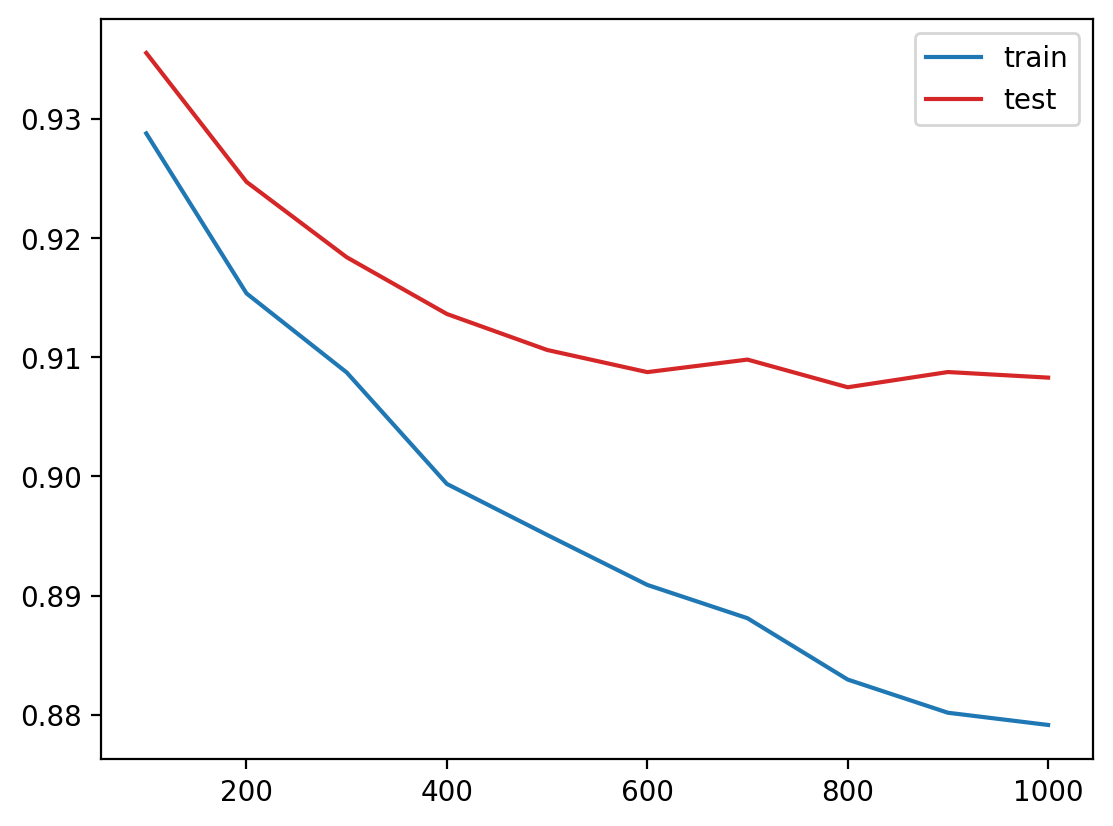

In [86]:
train_scores = []
test_scores = []
for dimensions in tqdm.tqdm(np.arange(100, 1100, 100)):
    mae_train, mae_test = word2vecLinearRegression(df_train, df_test, 'positive_tokensV1', 'negative_tokensV1',
                          dimensions, min_count, window, num_ns, epochs=epochs,
                          neg_sentiment=None, pos_sentiment=None)
    train_scores.append(mae_train)
    test_scores.append(mae_test)
    
plt.plot(np.arange(100, 1100, 100), train_scores, label = 'train', color = 'tab:blue')
plt.plot(np.arange(100, 1100, 100), test_scores, label = 'test', color = 'tab:red')
plt.legend()

In [95]:
print(f"Best test score: {np.round(np.min(test_scores),4)}")
print(f"Best number of dimension: {np.arange(100, 1100, 100)[np.argmin(test_scores)]}")

Best test score: 0.9075
Best number of dimension: 800


# word2vec + LinearRegression with IDF weights

In [101]:
class Word2VecRegression:
    def __init__(self, df_train, df_test,
                 neg_column, pos_column, y_column,
                 dimensions, min_count, window,
                 num_ns, idf_weights, epochs):
        self.df_train, self.df_test = df_train, df_test
        self.vector_size = dimensions
        self.min_count = min_count
        self.window = window
        self.negative = num_ns
        self.neg_column, self.pos_column = neg_column, pos_column
        self.y_column = y_column
        self.idf_weights = idf_weights
        self.epochs = epochs
        
        
        self.w2v_pos = self.Word2VecSpecification(df_train[pos_column])
        self.w2v_neg = self.Word2VecSpecification(df_train[neg_column])
    
    def Word2VecSpecification(self, sentences):
        w2v = Word2Vec(sentences,
                    vector_size = self.vector_size, 
                    min_count = self.min_count, 
                    window = self.window, sg = 1, 
                    hs = 0, negative = self.negative,
                    epochs = self.epochs, shrink_windows = False, 
                    workers = 10
                    ).wv
        return w2v
        
    def get_idf_dicts(self, data):
        idf_dicts = []
        columns = [self.neg_column, self.pos_column]
        for column in columns:
            wrds = set([wrd for wrd_list in data[column] for wrd in wrd_list])
            corpus = [' '.join(x) for x in data[column]]
            pipe = Pipeline([('count', CountVectorizer(vocabulary=wrds, lowercase=False)),
                            ('tfidf', TfidfTransformer())]).fit(corpus)
            idf_dict = dict(zip(wrds, pipe['tfidf'].idf_))      
            idf_dicts.append(idf_dict)  
        return idf_dicts
        
    def get_train_test(self):
        columns = [self.neg_column, self.pos_column]
        if self.idf_weights:
            [nidf_dict_train, pidf_dict_train] = self.get_idf_dicts(self.df_train)
            [nidf_dict_test, pidf_dict_test]  = self.get_idf_dicts(self.df_test)

            # train
            X_neg = np.array([self.w2v_neg.get_mean_vector(wrd_list, 
                                                    ignore_missing=True, 
                                                    weights = [nidf_dict_train[wrd] for wrd in wrd_list]) 
                            for wrd_list in self.df_train[self.neg_column]])
            X_pos = np.array([self.w2v_pos.get_mean_vector(wrd_list, 
                                                    ignore_missing=True, 
                                                    weights = [pidf_dict_train[wrd] for wrd in wrd_list]) 
                            for wrd_list in self.df_train[self.pos_column]])
            X_train = np.hstack([X_neg, X_pos])

            # test
            X_neg = np.array([self.w2v_neg.get_mean_vector(wrd_list, 
                                                    ignore_missing=True, 
                                                    weights = [nidf_dict_test[wrd] for wrd in wrd_list]) 
                            for wrd_list in self.df_test[self.neg_column]])
            X_pos = np.array([self.w2v_pos.get_mean_vector(wrd_list, 
                                                    ignore_missing=True, 
                                                    weights = [pidf_dict_test[wrd] for wrd in wrd_list]) 
                            for wrd_list in self.df_test[self.pos_column]])
            X_test = np.hstack([X_neg, X_pos])
        else:
            # train
            X_neg = np.array([self.w2v_neg.get_mean_vector(x, ignore_missing=True) for x in self.df_train[self.neg_column]])
            X_pos = np.array([self.w2v_pos.get_mean_vector(x, ignore_missing=True) for x in self.df_train[self.pos_column]])
            X_train = np.hstack([X_neg, X_pos])
            # test
            X_neg = np.array([self.w2v_neg.get_mean_vector(x, ignore_missing=True) for x in self.df_test[self.neg_column]])
            X_pos = np.array([self.w2v_pos.get_mean_vector(x, ignore_missing=True) for x in self.df_test[self.pos_column]])
            X_test = np.hstack([X_neg, X_pos])

        return X_train, X_test

    def fit(self):
        X_train, X_test = self.get_train_test()
        y_train, y_test = self.df_train[self.y_column], self.df_test[self.y_column]
        LR = LinearRegression()
        LR.fit(X_train, y_train)
        y_train_pred = LR.predict(X_train)
        y_test_pred = LR.predict(X_test)
        # correct for out of bounds scores
        y_train_pred = [x if x <= 10 else 10 for x in y_train_pred] # score <= 10
        y_train_pred = [x if x >= 0 else 0 for x in y_train_pred]   # score >= 0
        y_test_pred = [x if x <= 10 else 10 for x in y_test_pred]   # score <= 10
        y_test_pred = [x if x >= 0 else 0 for x in y_test_pred]     # score >= 0
        # scores
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
#         print(f"MAE Train: {mae_train}")
#         print(f"MAE Test: {mae_test}")
        return mae_train, mae_test

In [102]:
Word2VecRegression(df_train, df_test, 'negative_tokensV0', 'positive_tokensV0',
                             'score', dimensions = dimensions, min_count = min_count,
                             window = window, num_ns = num_ns, 
                             idf_weights = True, epochs = 10).fit()

(0.8796950949541728, 0.9019152182998657)

In [103]:
Word2VecRegression(df_train, df_test, 'negative_tokensV1', 'positive_tokensV1',
                             'score', dimensions = dimensions, min_count = min_count,
                             window = window, num_ns = num_ns, 
                             idf_weights = True, epochs = 10).fit()

(0.878580732316335, 0.9153224629631042)

100%|███████████████████████████████████████████| 10/10 [09:41<00:00, 58.19s/it]


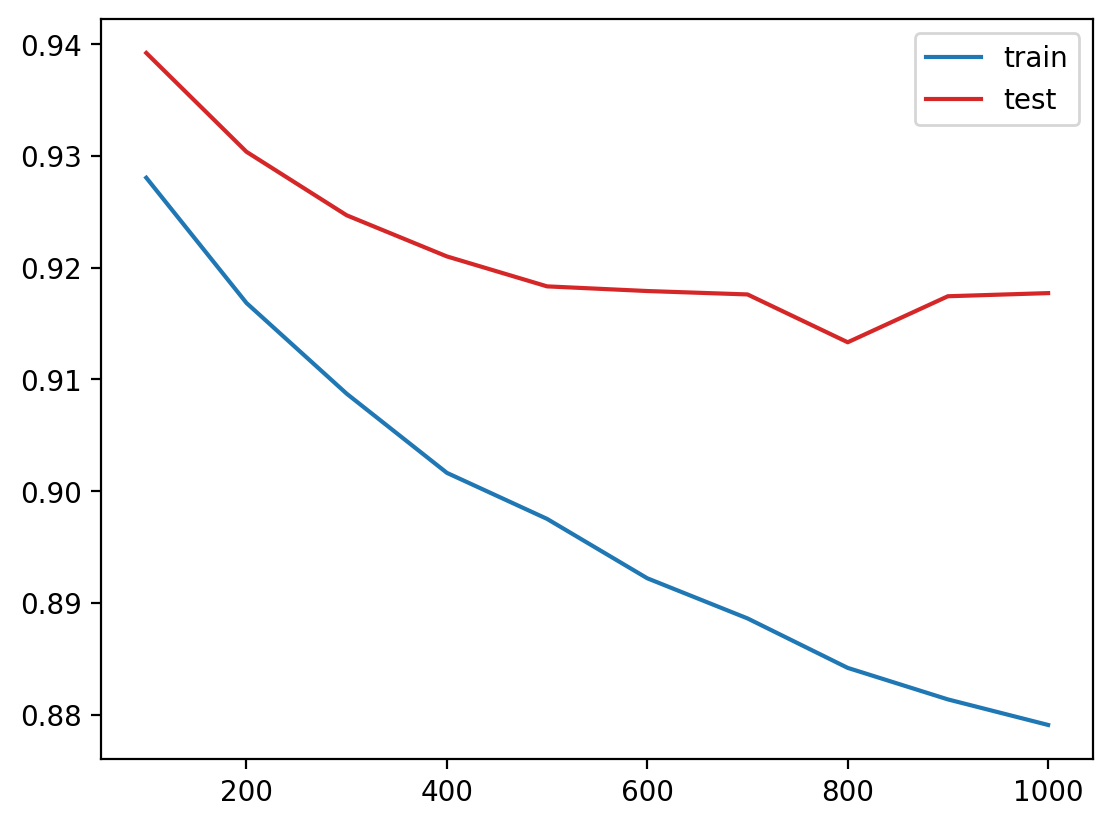

In [104]:
train_scores = []
test_scores = []
for dimensions in tqdm.tqdm(np.arange(100, 1100, 100)):
    mae_train, mae_test = Word2VecRegression(df_train, df_test, 'negative_tokensV1', 'positive_tokensV1',
                                             'score', dimensions = dimensions, min_count = min_count,
                                             window = window, num_ns = num_ns, 
                                             idf_weights = True, epochs = 10).fit()
    train_scores.append(mae_train)
    test_scores.append(mae_test)
    
plt.plot(np.arange(100, 1100, 100), train_scores, label = 'train', color = 'tab:blue')
plt.plot(np.arange(100, 1100, 100), test_scores, label = 'test', color = 'tab:red')
plt.legend()

In [105]:
print(f"Best test score: {np.round(np.min(test_scores),4)}")
print(f"Best number of dimension: {np.arange(100, 1100, 100)[np.argmin(test_scores)]}")

Best test score: 0.9133
Best number of dimension: 800


## Other Embeddings: FastText
[see](https://kavita-ganesan.com/fasttext-vs-word2vec/#.ZDttYS8Rr5g) and [see](https://radimrehurek.com/gensim/models/fasttext.html)

In [108]:
from gensim.models.fasttext import FastText

In [113]:
class FastTextRegression:
    def __init__(self, df_train, df_test,
                 neg_column, pos_column, y_column,
                 dimensions, min_count, window,
                 num_ns, idf_weights, epochs,
                 min_n, max_n):
        self.df_train, self.df_test = df_train, df_test
        self.vector_size = dimensions
        self.min_count = min_count
        self.window = window
        self.negative = num_ns
        self.neg_column, self.pos_column = neg_column, pos_column
        self.y_column = y_column
        self.idf_weights = idf_weights
        self.epochs = epochs
        self.min_n, self.max_n = min_n, max_n
        
    
        self.w2v_pos = self.FastTextSpecification(df_train[pos_column])
        self.w2v_neg = self.FastTextSpecification(df_train[neg_column])
    
    def FastTextSpecification(self, sentences):
        w2v = FastText(sentences,
                    vector_size = self.vector_size, 
                    min_count = self.min_count, 
                    window = self.window, sg = 1, 
                    hs = 0, negative = self.negative,
                    epochs = self.epochs, shrink_windows = False, 
                    min_n = self.min_n, max_n = self.max_n
                    ).wv
        return w2v
        
        
    def get_idf_dicts(self, data):
        idf_dicts = []
        columns = [self.neg_column, self.pos_column]
        for column in columns:
            wrds = set([wrd for wrd_list in data[column] for wrd in wrd_list])
            corpus = [' '.join(x) for x in data[column]]
            pipe = Pipeline([('count', CountVectorizer(vocabulary=wrds, lowercase=False)),
                            ('tfidf', TfidfTransformer())]).fit(corpus)
            idf_dict = dict(zip(wrds, pipe['tfidf'].idf_))      
            idf_dicts.append(idf_dict)  
        return idf_dicts
        
    def get_train_test(self):
        columns = [self.neg_column, self.pos_column]
        if self.idf_weights:
            [nidf_dict_train, pidf_dict_train] = self.get_idf_dicts(self.df_train)
            [nidf_dict_test, pidf_dict_test]  = self.get_idf_dicts(self.df_test)

            # train
            X_neg = np.array([self.w2v_neg.get_mean_vector(wrd_list, 
                                                    ignore_missing=True, 
                                                    weights = [nidf_dict_train[wrd] for wrd in wrd_list]) 
                            for wrd_list in self.df_train[self.neg_column]])
            X_pos = np.array([self.w2v_pos.get_mean_vector(wrd_list, 
                                                    ignore_missing=True, 
                                                    weights = [pidf_dict_train[wrd] for wrd in wrd_list]) 
                            for wrd_list in self.df_train[self.pos_column]])
            X_train = np.hstack([X_neg, X_pos])

            # test
            X_neg = np.array([self.w2v_neg.get_mean_vector(wrd_list, 
                                                    ignore_missing=True, 
                                                    weights = [nidf_dict_test[wrd] for wrd in wrd_list]) 
                            for wrd_list in self.df_test[self.neg_column]])
            X_pos = np.array([self.w2v_pos.get_mean_vector(wrd_list, 
                                                    ignore_missing=True, 
                                                    weights = [pidf_dict_test[wrd] for wrd in wrd_list]) 
                            for wrd_list in self.df_test[self.pos_column]])
            X_test = np.hstack([X_neg, X_pos])
        else:
            # train
            X_neg = np.array([self.w2v_neg.get_mean_vector(x, ignore_missing=True) for x in self.df_train[self.neg_column]])
            X_pos = np.array([self.w2v_pos.get_mean_vector(x, ignore_missing=True) for x in self.df_train[self.pos_column]])
            X_train = np.hstack([X_neg, X_pos])
            # test
            X_neg = np.array([self.w2v_neg.get_mean_vector(x, ignore_missing=True) for x in self.df_test[self.neg_column]])
            X_pos = np.array([self.w2v_pos.get_mean_vector(x, ignore_missing=True) for x in self.df_test[self.pos_column]])
            X_test = np.hstack([X_neg, X_pos])

        return X_train, X_test

    def fit(self):
        X_train, X_test = self.get_train_test()
        y_train, y_test = self.df_train[self.y_column], self.df_test[self.y_column]
        LR = LinearRegression()
        LR.fit(X_train, y_train)
        y_train_pred = LR.predict(X_train)
        y_test_pred = LR.predict(X_test)
        # correct for out of bounds scores
        y_train_pred = [x if x <= 10 else 10 for x in y_train_pred] # score <= 10
        y_train_pred = [x if x >= 0 else 0 for x in y_train_pred]   # score >= 0
        y_test_pred = [x if x <= 10 else 10 for x in y_test_pred]   # score <= 10
        y_test_pred = [x if x >= 0 else 0 for x in y_test_pred]     # score >= 0
        # scores
        mae_train = mean_absolute_error(y_train, y_train_pred)
        mae_test = mean_absolute_error(y_test, y_test_pred)
#         print(f"MAE Train: {mae_train}")
#         print(f"MAE Test: {mae_test}\n")
        return mae_train, mae_test   
    

### Training with 300 dimensions: FastText vs. word2vec

In [119]:
print('-->w/o IDF weights<--')
FastTextRegression(df_train, df_test, 'negative_tokensV1', 'positive_tokensV1',
                   'score', dimensions = 300, min_count = min_count,
                   window = window, num_ns = num_ns, 
                   idf_weights = False, epochs = 10,
                   min_n = 3, max_n = 6).fit()

-->w/o IDF weights<--


(0.9099441762682597, 0.9178718405570984)

In [176]:
print('-->w/ IDF weights<--')
FastTextRegression(df_train, df_test, 'negative_tokensV1', 'positive_tokensV1',
                   'score', dimensions = 300, min_count = min_count,
                   window = window, num_ns = num_ns, 
                   idf_weights = True, epochs = 10,
                   min_n = 3, max_n = 6).fit()

-->w/ IDF weights<--


(0.9104867882334391, 0.9241048234634399)

In [177]:
print('-->Comparison: word2vec w/o IDF weights<--')
Word2VecRegression(df_train, df_test, 'negative_tokensV1', 'positive_tokensV1',
                   'score', dimensions = 300, min_count = min_count,
                   window = window, num_ns = num_ns, 
                   idf_weights = False, epochs = 10).fit()

-->Comparison: word2vec w/o IDF weights<--


(0.9070209678223927, 0.9169806029491425)

## Conclusions

**Best Performances**
- TF-IDF + LinearRegression: $0.8324$
- word2vec + LinearRegression: $0.9093$
- word2vec + LinearRegresssion with IDF weights: $0.9019$ (without preprocessing, with preprocessing performs worse)


**Conclusions**

1. *Subsampling* does not help
2. Preprocessing routine leads to improved performance for most of the models